In [1]:
import pandas as pd 
import numpy as np 
from scipy.optimize import minimize 
df = pd.read_csv("ARP_Returns.csv")
for i,j in enumerate(list(df.columns[1:])):
    print(i+1,j)

1 Equity Momentum
2 Equity Low Beta
3 Equity Quality
4 Commodity Carry
5 Commodity Curve
6 Credit Curve
7 Credit Carry
8 FX Carry
9 FX Value
10 Interest Rate Spread
11 Interest Rate Curve
12 Equity Trend
13 FX Trend
14 Commodity Trend
15 Interest Rate Trend
16 Commodity Volatility Carry
17 Interest Rate Volatility Carry
18 Equity Volatility Carry
19 COT
20 Merger Arb


In [2]:
def cal_return(df):
    df_norm = pd.DataFrame()
    df_return = pd.DataFrame()
    df_return['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
    df_norm['Date'] = df_return['Date']
    strategy_list = list(df.columns[1:])
    for strategy in strategy_list:
        cleaned_name = strategy.lower().replace(' ', '_')
        df_norm[cleaned_name] = df[strategy]/df[strategy].iloc[0]
        df_return[cleaned_name] = df_norm[cleaned_name].diff()/df_norm[cleaned_name]
    return df_norm, df_return
df_norm, df_return = cal_return(df)

In [3]:
# print each strategy performance
import matplotlib.pyplot as plt 
for strategy in df_norm.columns[1:]:
    plt.figure(figsize=(12,6))
    plt.plot(df_norm['Date'], df_norm[strategy])
    plt.title(strategy)
    

In [5]:
def get_stats(weights, df_return):
    weights = np.array(weights)
    ret = np.sum(df_return.mean() * weights) * 252 
    PortVariance = np.dot(weights.T, np.dot(df_return.cov(), weights)) * 252 
    sharpe_ratio = ret/np.sqrt(PortVariance)
    vol = np.std(df_return) * np.sqrt(252)
    div = np.sum(vol * weights)/np.sqrt(PortVariance)
    return [ret, np.sqrt(PortVariance), sharpe_ratio, div]

def neg_sharpe(weights, df_return):
    return get_stats(weights, df_return)[2] * (-1)

def neg_diversification(weights, df_return):
    return get_stats(weights, df_return)[3] * (-1)

def check_sum(weights):
    return np.sum(weights) - 1

In [6]:
def portfolio_optimisation(df_return=df_return, 
                           cutoff_date='2000-01-01', 
                           upper_bound=1,
                           drop_strategy=['equity_momentum'],
                           target='sharpe'):
    
    df_return = df_return[df_return['Date']>cutoff_date]
    
    try:
        df_return = df_return.drop(drop_strategy, axis=1)
    except:
        pass 

    
    num_strategies = len(df_return.columns) - 1
    
    init_guess = np.array(np.random.random(num_strategies))
    init_guess /= np.sum(init_guess)
    
    cons = ({'type': 'eq', 'fun': check_sum})
    bounds = tuple([(0,upper_bound) for i in range(num_strategies)])
    opt_results = minimize(fun=neg_sharpe, 
                           x0=init_guess, 
                           args=(df_return),
                           method='SLSQP', 
                           bounds=bounds, 
                           constraints=cons)

    ret, PortVariance, sharpe_ratio, div = get_stats(opt_results.x, df_return)
    
    df_portfolio = df_return[df_return.columns[1:]] * opt_results.x
    df_portfolio_sum = pd.DataFrame()
    df_portfolio_sum['Date'] = df_return['Date']
    df_portfolio_sum['perf'] = (1+df_portfolio.sum(axis=1)).cumprod()
    plt.plot(df_portfolio_sum['Date'], df_portfolio_sum['perf'])
    
    return -opt_results.fun, df_portfolio_sum, opt_results.x, ret, PortVariance, div

In [7]:
settings = [
            ('2009-01-01', 1, None), 
            # ('2015-09-01', 1, None),
            # ('2017-09-01', 1, None),
            # ('2009-01-01', 0.1, None),
            # ('2015-09-01', 0.1, None),
            # ('2017-09-01', 0.1, None),
            # ('2009-01-01', 1, 'equity_trend'), 
            # ('2015-09-01', 1, 'equity_trend'),
            # ('2017-09-01', 1, 'equity_trend'),
            # ('2009-01-01', 0.1, 'equity_trend'),
            # ('2015-09-01', 0.1, 'equity_trend'),
            # ('2017-09-01', 0.1, 'equity_trend')
           ]

result = {} 

('2009-01-01', 1, None)
Wall time: 31.9 s


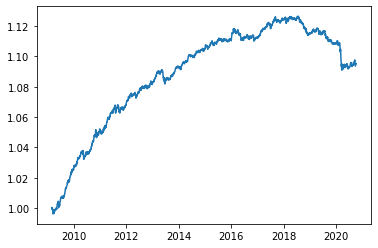

In [8]:
%%time
for config in settings:
    print(config)
    result[config] = portfolio_optimisation(df_return, 
                                            cutoff_date=config[0],
                                            upper_bound=config[1],
                                            drop_strategy=config[2])

In [16]:
result[(('2009-01-01', 1, None))][2] * 100 

array([ 1.76357209,  8.86871375, 10.02732567,  0.26008276,  3.37443248,
       11.32979732,  4.5437187 ,  2.15752801,  4.36542519, 20.55021289,
        6.42389953,  2.46273093,  2.97911475,  1.48682094,  2.4014816 ,
        0.92453002,  1.29980643,  1.58710034, 10.13278525,  3.06092134])

In [18]:
result[(('2009-01-01', 1, None))][0] 

3.748813959098972

In [22]:
result[(('2009-01-01', 1, None))][1].tail()

,Date,perf
3021,2020-10-01,1.094916
3022,2020-10-02,1.095204
3023,2020-10-05,1.095190
3024,2020-10-06,1.095089
3025,2020-10-07,1.095185


In [23]:
# for i, config in enumerate(settings): 
#     print('=================================================================')
#     print(i+1, config)
#     print('SHARPE: ', result[config][0])
#     print('RETURN: ', result[config][3])
#     print('PORTFOLIO VOL ', result[config][4])
#     print('DIVERSIFICATION ', result[config][5])
#     result[config][1].to_csv(config[0]+'_'+ str(config[1])+'_'+str(config[2])+'.csv')
#     print(result[config][2])

1

In [24]:
# for i, config in enumerate(settings): 
#     print('=================================================================')
#     print(i+1, config)
#     print(result[config][2]) 
#     df_weights = pd.DataFrame()
#     df_weights['val'] = result[config][2]
#     df_weights.to_csv('WEIGHTS_'+config[0]+'_'+ str(config[1])+'_'+str(config[2])+'.csv')